# Oil Palm Disease Detection

## Data Acquisition

Data collected from kaggle private dataset. The data was manually selected to 1000 out of a total of about 3000 images each class. Follow these steps:

0. Download the dataset and extract it.
1. Create `data` folder and put the extracted folder in here. `data` folder should now have 1 folder named `selected_dataset` inside.
2. Follow the code.

In [1]:
import os
import shutil

SELECTED_DATA = os.path.join('data', 'selected_dataset')
ORIGINAL_DATA = os.path.join('data', 'cleaned_dataset')
PROCESSED_DATASET = os.path.join('data', 'processed_dataset')
SAMPLE_IMAGE = 'data/selected_dataset/normal/DSC03990_5.JPG'

In [ ]:
def copy_selected(label: str) -> None:
    with open(f'selected_data_{label}.txt', 'r') as f:
        selected_list = [x.strip() for x in f.readlines()]
    for image_file in selected_list:
        src = os.path.join(ORIGINAL_DATA, label, image_file)
        dst = os.path.join(SELECTED_DATA, label, image_file)
        shutil.copyfile(src, dst)

copy_selected('normal')
copy_selected('infected')

## Preprocessing Image

Preprocessing image consist of image enhancing using histogram equalization and noise removal using bilateral smoothing filter.

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Union

In [3]:
def enhance(image: Union[str, np.ndarray], display: bool = False) -> np.ndarray:
    """
    Enhance image by using adaptive histogram equalization
    :param display: bool, if true then return converted image in RGB, if not, return as BGR because it needs to continue to another preprocessing
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :return: np.ndarray, numpy array of enhance image
    """
    if type(image) is str:
        image = cv2.imread(image)
    # convert from BGR to YCrCb
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    # create clahe object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # equalize the histogram of the Y channel
    ycrcb[:, :, 0] = clahe.apply(ycrcb[:, :, 0])
    # convert the YCR_CB image back to RGB format
    if display:
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    else:
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR)

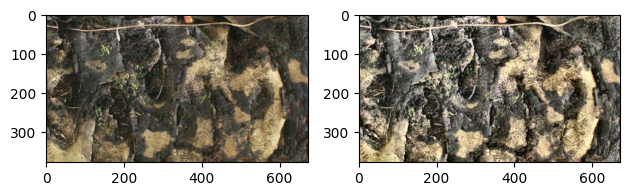

In [4]:
# cv2.imwrite('data/samples/equalized_img.jpg', enhance('data/selected_dataset/normal/DSC03977_4.JPG'))
# cv2.waitKey(0)
def compare_image(image: str, processed_image: np.ndarray):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(Image.open(image))
    ax[1].imshow(processed_image)
    plt.tight_layout()

compare_image(SAMPLE_IMAGE, enhance(SAMPLE_IMAGE, display=True))

In [5]:
def remove_noise(image: Union[str, np.ndarray], filter: str = 'bilateral', display: bool = False) -> np.ndarray:
    """
    Remove noise from image using bilateral filter
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :return: np.ndarray, numpy array of image with removed noise
    """
    if type(image) is str:
        image = cv2.imread(image)
    # apply bilateral filter with d = 15, sigmaColor = sigmaSpace = 75.

    if filter == 'bilateral':
        filtered_image = cv2.bilateralFilter(image, 10, 65, 65)
    else:
        filtered_image = cv2.medianBlur(image, 5)

    if display:
        return cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)
    return filtered_image

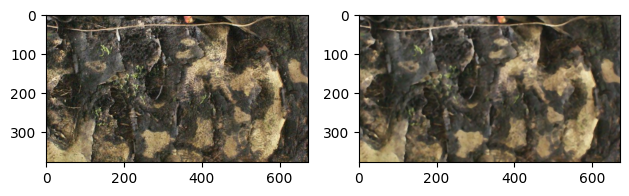

In [8]:
compare_image(SAMPLE_IMAGE, remove_noise(SAMPLE_IMAGE, filter='median', display=True))

## Feature Extraction

Feature extraction using LBP, Color moments, and Hu-moments.

In [2]:
import cv2
from skimage import io
from skimage.feature import local_binary_pattern
import numpy as np
from typing import Union

In [3]:
def lbp(image: Union[np.ndarray, str], radius: int = 3,  n_points: int = 8, methods: str = 'uniform') -> np.ndarray:
    """
    Calculate Local Binary Pattern of an image.
    :param image: input image
    :param radius: radius of LBP
    :param n_points: number of points
    :return: LBP histogram
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    lbp = local_binary_pattern(image, n_points, radius, method=methods)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    # normalize the histogram
    # hist = hist.astype('float')
    # hist /= (hist.sum() + 1e-7)

    return hist.astype('float')

lbp(SAMPLE_IMAGE)

array([20751., 24686., 16712., 17377., 19412., 16729., 16137., 24458.,
       22868., 74886.])

In [4]:
def color_moment(image: Union[np.ndarray, str]) -> np.ndarray:
    """
    Calculate color moment of an image (mean, standard deviation, skewness, kurtosis).
    :param image: input image
    :return: color moment
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = io.imread(image)
    # mean of each channel
    mean = np.mean(image, axis=(0, 1))
    # standard deviation of each channel
    std = np.std(image, axis=(0, 1))
    # skewness of each channel
    skew = np.mean(np.power(image - mean, 3)) / np.power(std, 3)
    # kurtosis of each channel
    kurt = np.mean(np.power(image - mean, 4)) / np.power(std, 4)
    return np.concatenate((mean, std, skew, kurt))

color_moment(SAMPLE_IMAGE)

array([92.32898715, 83.8765314 , 67.20685311, 49.26675293, 43.04963224,
       34.40291865,  0.61395685,  0.92021929,  1.80307505,  1.91872026,
        3.29116486,  8.06949331])

In [5]:
def hu_moment(image: Union[np.ndarray, str]) -> np.ndarray:
    """
    Calculate Hu moment of an image.
    :param image: input image
    :return: Hu moment
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # compute moments
    moments = cv2.HuMoments(cv2.moments(image)).flatten()
    return moments

hu_moment(SAMPLE_IMAGE)

array([ 2.30352710e-03,  1.36658857e-06,  7.30230907e-11,  7.99031976e-11,
        4.03872355e-21,  8.80721041e-14, -4.57613129e-21])

In [6]:
import csv

# combine all feature
f = open(os.path.join('data', 'features.csv'), 'w', newline='')
writer = csv.writer(f)

class_map = {'infected': 1, 'normal':0}
for image_class in os.listdir(os.path.join(PROCESSED_DATASET)):
    for image_file in os.listdir(os.path.join(PROCESSED_DATASET, image_class)):
        image_path = os.path.join(PROCESSED_DATASET, image_class, image_file)
        extracted_lbp = lbp(image_path)
        extracted_color_moment = color_moment(image_path)
        extracted_humoment = hu_moment(image_path)
        all_features = np.concatenate([extracted_lbp, extracted_color_moment, extracted_humoment])
        # print(all_features)

        # write to csv. Column position is as follows
        # first column would be image class. 0 for normal, 1 for infected. Then, next columns would be
        # 10 lbp feature, 12 color moment feature, and 7 hu-moment
        data = all_features.tolist()
        data.insert(0, class_map[image_class])
        writer.writerow(data)

f.close()